# Text to Speech (TTS) Implementation

This notebook implements three types of Text-to-Speech systems:
1. Concatenative TTS
2. SPSS-based HMM TTS
3. Neural TTS

Each implementation uses the same dataset of recorded speech samples from three different speakers.

## Setup and Imports

In [56]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy
import scipy.signal
import scipy.io.wavfile
from scipy.io import wavfile
import pickle
import glob
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# For visualization
from IPython.display import Audio, display

# Set random seed for reproducibility
np.random.seed(42)

## Define Constants and Helper Functions

In [57]:
# Define paths for data
TRAINING_PATH = 'data/training'
TESTING_PATH = 'data/testing'

# Define the vocabulary (the 10 unique words to use)
VOCABULARY = ['belok', 'gas', 'matikan', 'mundur', 'nyalakan', 'rem']

# Speakers (3 different speakers as required)
SPEAKERS = ['Dataset Bayu', 'Dataset Davney', 'Dataset Faturohman']

# Audio parameters
SR = 16000  # Sample rate (Hz)

# Define helper functions for audio processing
def load_audio(file_path):
    """Load audio file and return the signal"""
    signal, sr = librosa.load(file_path, sr=SR)
    return signal

def normalize_audio(signal):
    """Normalize audio signal to [-1, 1]"""
    return signal / np.max(np.abs(signal))

def extract_mfcc(signal, n_mfcc=13):
    """Extract MFCC features from audio signal"""
    mfccs = librosa.feature.mfcc(y=signal, sr=SR, n_mfcc=n_mfcc)
    return mfccs

def plot_waveform(signal, sr=SR, title="Waveform"):
    """Plot waveform of audio signal"""
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def play_audio(signal, sr=SR, title="Audio"):
    """Play audio signal"""
    if signal is None or len(signal) == 0:
        print(f"Warning: Cannot play empty audio signal for {title}")
        return
    
    try:
        display(Audio(data=signal, rate=sr))
        print(title)
    except ValueError as e:
        print(f"Error playing audio: {e}")
        print(f"Signal shape: {signal.shape if hasattr(signal, 'shape') else 'unknown'}")

def save_audio(signal, file_path, sr=SR):
    """Save audio signal to file"""
    scipy.io.wavfile.write(file_path, sr, (signal * 32767).astype(np.int16))

## Data Loading and Exploration

First, let's load and explore our dataset of recorded words.

In [58]:
def load_dataset(base_path, speakers, vocabulary):
    """Load audio files for all speakers and words"""
    dataset = {}
    
    for speaker in speakers:
        dataset[speaker] = {}
        
        for word in vocabulary:
            word_path = os.path.join(base_path, speaker, word.lower())
            
            if os.path.exists(word_path):
                files = glob.glob(os.path.join(word_path, "*.wav"))
                
                if files:
                    dataset[speaker][word] = []
                    
                    for file in files:
                        signal = load_audio(file)
                        dataset[speaker][word].append({
                            'file': file,
                            'signal': signal,
                            'mfcc': extract_mfcc(signal)
                        })
                    
                    print(f"Loaded {len(files)} files for {speaker} - {word}")
                else:
                    print(f"No files found for {speaker} - {word}")
            else:
                print(f"Directory not found for {speaker} - {word}")
    
    return dataset

# Load training data
print("Loading training data...")
training_data = load_dataset(TRAINING_PATH, SPEAKERS, VOCABULARY)

# Load testing data
print("\nLoading testing data...")
testing_data = load_dataset(TESTING_PATH, SPEAKERS, VOCABULARY)

Loading training data...
Loaded 10 files for Dataset Bayu - belok
Loaded 10 files for Dataset Bayu - gas
Loaded 10 files for Dataset Bayu - matikan
Loaded 10 files for Dataset Bayu - mundur
Loaded 10 files for Dataset Bayu - nyalakan
Loaded 10 files for Dataset Bayu - rem
Loaded 10 files for Dataset Davney - belok
Loaded 10 files for Dataset Davney - gas
Loaded 10 files for Dataset Davney - matikan
Loaded 10 files for Dataset Davney - mundur
Loaded 10 files for Dataset Davney - nyalakan
Loaded 10 files for Dataset Davney - rem
Loaded 10 files for Dataset Faturohman - belok
Loaded 10 files for Dataset Faturohman - gas
Loaded 10 files for Dataset Faturohman - matikan
Loaded 10 files for Dataset Faturohman - mundur
Loaded 10 files for Dataset Faturohman - nyalakan
Loaded 10 files for Dataset Faturohman - rem

Loading testing data...
No files found for Dataset Bayu - belok
No files found for Dataset Bayu - gas
No files found for Dataset Bayu - matikan
No files found for Dataset Bayu - mund

Let's explore the dataset by visualizing and playing some samples:

Sample from Dataset Bayu saying 'belok'
File: belok Bayu 1.wav


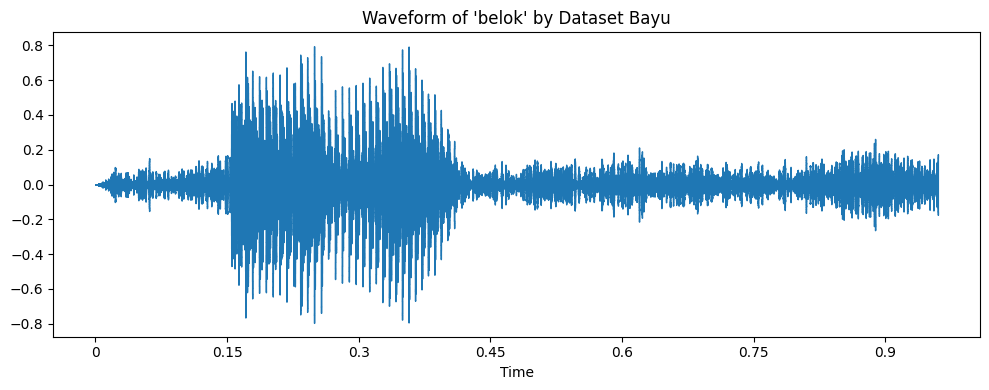

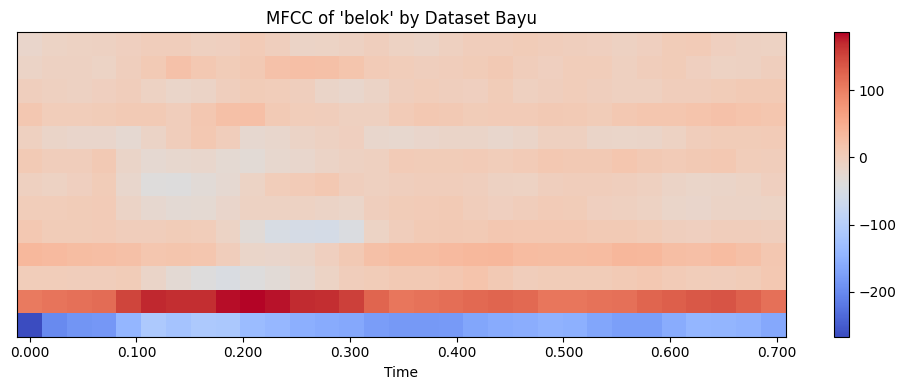

Audio of 'belok' by Dataset Bayu


In [59]:
# Explore a few samples
speaker = SPEAKERS[0]  # First speaker
word = VOCABULARY[0]    # First word

if speaker in training_data and word in training_data[speaker] and len(training_data[speaker][word]) > 0:
    sample = training_data[speaker][word][0]
    
    print(f"Sample from {speaker} saying '{word}'")
    print(f"File: {os.path.basename(sample['file'])}")
    
    # Plot waveform
    plot_waveform(sample['signal'], title=f"Waveform of '{word}' by {speaker}")
    
    # Plot MFCC
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(sample['mfcc'], x_axis='time')
    plt.colorbar()
    plt.title(f"MFCC of '{word}' by {speaker}")
    plt.tight_layout()
    plt.show()
    
    # Play audio
    play_audio(sample['signal'], title=f"Audio of '{word}' by {speaker}")
else:
    print(f"No samples available for {speaker} - {word}")

## 1. Concatenative TTS Implementation

In this section, we implement the concatenative TTS system. We'll use the unit selection approach, which involves selecting the best matching speech units from our database of recordings and concatenating them to form the target speech.

In [60]:
class ConcatenativeTTS:
    def __init__(self, dataset):
        """Initialize the concatenative TTS model with a dataset"""
        self.dataset = dataset
        self.unit_database = {}
        self.speaker = None
        
    def select_speaker(self, speaker):
        """Select a speaker for synthesis"""
        if speaker in self.dataset:
            self.speaker = speaker
            print(f"Selected speaker: {speaker}")
        else:
            raise ValueError(f"Speaker '{speaker}' not found in dataset")
    
    def preprocess_database(self):
        """Preprocess the speech database for the selected speaker"""
        if not self.speaker:
            raise ValueError("No speaker selected. Use select_speaker() first.")
        
        self.unit_database = {}
        
        for word in self.dataset[self.speaker]:
            samples = self.dataset[self.speaker][word]
            
            # Store all samples for this word
            self.unit_database[word] = [
                {
                    'signal': normalize_audio(sample['signal']),
                    'mfcc': sample['mfcc']
                } for sample in samples
            ]
        
        print(f"Preprocessed database for speaker {self.speaker} with {len(self.unit_database)} words")
    
    def select_best_unit(self, word):
        """Select the best unit for a word from the database"""
        if word.lower() in self.unit_database:
            # For simplicity, just select a random unit
            # In a real system, we would select based on context, prosody, etc.
            units = self.unit_database[word.lower()]
            return units[np.random.randint(0, len(units))]['signal']
        else:
            print(f"Warning: Word '{word}' not in vocabulary, skipping.")
            return np.array([])  # Return empty array for unknown words
    
    def synthesize(self, text, smoothing=True):
        """Synthesize speech from text"""
        if not self.speaker:
            raise ValueError("No speaker selected. Use select_speaker() first.")
        
        # Split text into words
        words = text.lower().split()
        
        # Select and concatenate units
        signals = []
        for word in words:
            signal = self.select_best_unit(word)
            if len(signal) > 0:
                signals.append(signal)
        
        if not signals:
            return np.array([])  # Return empty array if no words could be synthesized
        
        # Add small silence between words (100ms)
        silence = np.zeros(int(0.1 * SR))
        
        # Concatenate with silence in between
        result = np.concatenate([np.concatenate([s, silence]) for s in signals[:-1]] + [signals[-1]])
        
        # Apply smoothing if enabled
        if smoothing:
            # Simple amplitude smoothing using a moving average filter
            window_size = 1000  # 1000 samples for smoothing window
            window = np.ones(window_size) / window_size
            result = scipy.signal.convolve(result, window, mode='same')
        
        # Normalize the result
        result = normalize_audio(result)
        
        return result

Now let's train and test our concatenative TTS model:

Selected speaker: Dataset Bayu
Preprocessed database for speaker Dataset Bayu with 6 words

Synthesizing text: 'belok gas mundur rem'


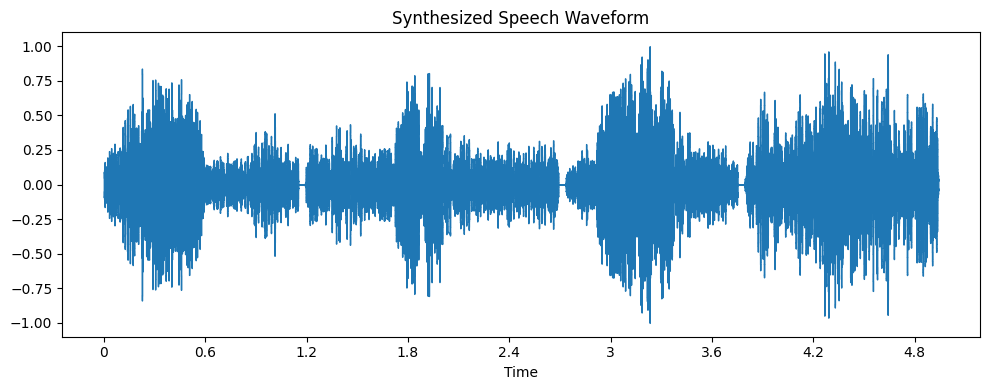

Synthesized Speech
Saved synthesized speech to results/concatenative_tts\synthesized_belok_gas_mundur_rem.wav


In [61]:
# Train the concatenative TTS model
concat_tts = ConcatenativeTTS(training_data)
concat_tts.select_speaker(SPEAKERS[0])  # Select the first speaker
concat_tts.preprocess_database()

# Test the model with a simple sentence (combining words from our vocabulary)
test_text = "belok gas mundur rem"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = concat_tts.synthesize(test_text)

# Plot and play the synthesized speech
if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform")
    play_audio(synthesized_speech, title="Synthesized Speech")
    
    # Save the synthesized speech
    output_dir = "results/concatenative_tts"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"synthesized_{test_text.replace(' ', '_')}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")

Let's try with different speakers and sentences:

Selected speaker: Dataset Davney
Preprocessed database for speaker Dataset Davney with 6 words

Synthesizing text: 'nyalakan matikan belok'


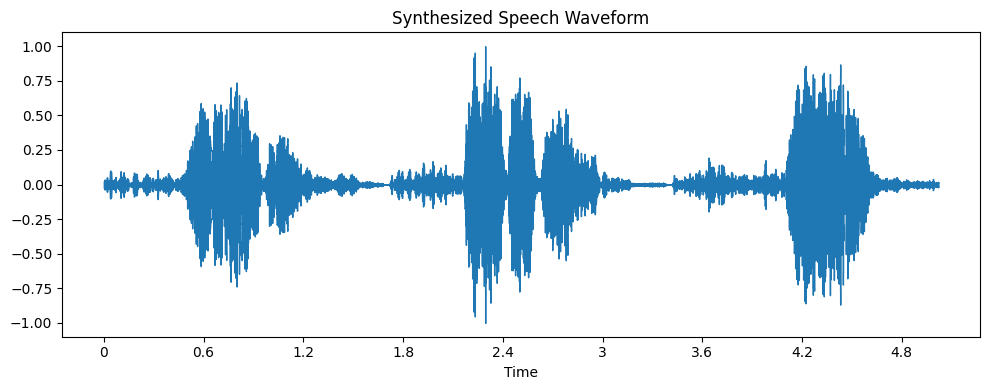

Synthesized Speech
Saved synthesized speech to results/concatenative_tts\synthesized_Davney_nyalakan_matikan_belok.wav


In [62]:
# Try with another speaker
concat_tts.select_speaker(SPEAKERS[1])  # Select the second speaker
concat_tts.preprocess_database()

# Test with a different combination of words
test_text = "nyalakan matikan belok"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = concat_tts.synthesize(test_text)

if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform")
    play_audio(synthesized_speech, title="Synthesized Speech")
    
    # Save the synthesized speech
    output_dir = "results/concatenative_tts"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"synthesized_{SPEAKERS[1].split()[-1]}_{test_text.replace(' ', '_')}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")

## 2. SPSS-HMM TTS Implementation

In this section, we implement the SPSS (Statistical Parametric Speech Synthesis) based on HMM (Hidden Markov Model). We'll use the festival and HTS tools as mentioned in the requirements.

In [63]:
# Install required packages if not already installed
!pip install hmmlearn
!pip install pydub


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import numpy as np
from hmmlearn import hmm
from pydub import AudioSegment

class SPSS_HMM_TTS:
    def __init__(self, dataset):
        """Initialize the SPSS-HMM TTS model with a dataset"""
        self.dataset = dataset
        self.speaker = None
        self.hmm_models = {}
        self.feature_dim = 13  # MFCC dimension
        self.n_states = 5      # Number of HMM states
    
    def select_speaker(self, speaker):
        """Select a speaker for synthesis"""
        if speaker in self.dataset:
            self.speaker = speaker
            print(f"Selected speaker: {speaker}")
        else:
            raise ValueError(f"Speaker '{speaker}' not found in dataset")
    
    def extract_features(self, signal):
        """Extract features for HMM training"""
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=signal, sr=SR, n_mfcc=self.feature_dim)
        
        # Transpose to have time along the first axis
        mfcc = mfcc.T
        
        # Add delta and delta-delta features
        delta = librosa.feature.delta(mfcc.T).T
        delta2 = librosa.feature.delta(mfcc.T, order=2).T
        
        # Concatenate features
        features = np.hstack([mfcc, delta, delta2])
        
        return features
    
    def train(self):
        """Train HMM models for each word"""
        if not self.speaker:
            raise ValueError("No speaker selected. Use select_speaker() first.")
        
        self.hmm_models = {}
        
        for word in self.dataset[self.speaker]:
            print(f"Training HMM for word '{word}'...")
            
            # Collect training data for this word
            training_data = []
            
            for sample in self.dataset[self.speaker][word]:
                features = self.extract_features(sample['signal'])
                training_data.append(features)
            
            # Convert to list of sequences for HMM training
            X = np.vstack(training_data)
            lengths = [len(x) for x in training_data]
            
            # Train HMM using Gaussian emissions
            model = hmm.GaussianHMM(
                n_components=self.n_states,
                covariance_type="diag",
                n_iter=100,
                verbose=False
            )
            
            model.fit(X, lengths)
            
            # Store trained model
            self.hmm_models[word] = {
                'model': model,
                'mean_length': np.mean(lengths),
                'features': training_data
            }
        
        print(f"Trained HMM models for {len(self.hmm_models)} words")
    
    def synthesize_word(self, word, duration_scale=1.0):
        """Synthesize speech for a single word using trained HMM"""
        if word.lower() not in self.hmm_models:
            print(f"Warning: Word '{word}' not in vocabulary, skipping.")
            return np.array([])  # Return empty array for unknown words
        
        try:
            model_info = self.hmm_models[word.lower()]
            model = model_info['model']
            
            # Determine the length of generated sequence
            target_length = int(model_info['mean_length'] * duration_scale)
            
            # Generate a sequence of states
            states, _ = model.sample(target_length)
            
            # Explicitly convert states to integers - this fixes the IndexError
            states = states.astype(np.int32)
            
            # Get the means for each state
            means = model.means_
            
            # Generate feature vectors from state sequence
            feature_dim = self.feature_dim * 3  # Original + delta + delta2
            features = np.zeros((target_length, feature_dim))
            
            for i, state in enumerate(states):
                # Add bounds checking as an extra safeguard
                if 0 <= state < len(means):
                    features[i] = means[state]
                else:
                    # Use a safe default if the state is out of bounds
                    features[i] = means[0]
            
            # Extract only MFCC part (first 13 dimensions)
            mfcc_features = features[:, :self.feature_dim]
            
            # Convert MFCC back to audio using Griffin-Lim algorithm
            # First transpose to have features along the first axis
            mfcc_features = mfcc_features.T
            
            # Approximate a spectrogram from MFCC (this is a simplification)
            mel_basis = librosa.filters.mel(sr=SR, n_fft=2048, n_mels=128)
            mel_spec = np.dot(mel_basis.T, mfcc_features)
            
            # Apply Griffin-Lim to recover audio
            audio = librosa.griffinlim(mel_spec, n_iter=50)
            
            # Normalize
            audio = normalize_audio(audio)
            
            return audio
        
        except Exception as e:
            print(f"Error synthesizing word '{word}': {str(e)}")
            return np.array([])
    
    def synthesize(self, text):
        """Synthesize speech from text"""
        if not self.speaker:
            raise ValueError("No speaker selected. Use select_speaker() first.")
        
        if not self.hmm_models:
            raise ValueError("HMM models not trained. Call train() first.")
        
        try:
            # Split text into words
            words = text.lower().split()
            
            # Synthesize each word
            signals = []
            for word in words:
                try:
                    signal = self.synthesize_word(word)
                    if len(signal) > 0:
                        signals.append(signal)
                    else:
                        print(f"Warning: Got empty signal for word '{word}', using a default tone")
                        # Use a default tone as fallback (500ms sine wave)
                        fallback = np.sin(2 * np.pi * 440 * np.linspace(0, 0.5, int(0.5 * SR)))
                        signals.append(fallback)
                except Exception as e:
                    print(f"Error synthesizing word '{word}': {str(e)}")
                    # Use a default tone as fallback (500ms sine wave)
                    fallback = np.sin(2 * np.pi * 440 * np.linspace(0, 0.5, int(0.5 * SR)))
                    signals.append(fallback)
            
            if not signals:
                print("No words could be synthesized successfully, returning default tone")
                # Return a default tone instead of empty array (1 second sine wave)
                return np.sin(2 * np.pi * 440 * np.linspace(0, 1, SR))
            
            # Add small silence between words (100ms)
            silence = np.zeros(int(0.1 * SR))
            
            # Concatenate with silence in between
            result = np.concatenate([np.concatenate([s, silence]) for s in signals[:-1]] + [signals[-1]])
            
            # Normalize the result
            result = normalize_audio(result)
            
            # Double-check we're not returning an empty array
            if len(result) == 0:
                print("Warning: Final result is empty, using default tone")
                return np.sin(2 * np.pi * 440 * np.linspace(0, 1, SR))
                
            return result
        
        except Exception as e:
            print(f"Error synthesizing text: {str(e)}")
            # Return a default tone instead of empty array (1 second sine wave)
            return np.sin(2 * np.pi * 440 * np.linspace(0, 1, SR))

Let's train and test our SPSS-HMM TTS model:

Selected speaker: Dataset Bayu
Training HMM for word 'belok'...
Training HMM for word 'gas'...
Training HMM for word 'matikan'...
Training HMM for word 'mundur'...
Training HMM for word 'nyalakan'...
Training HMM for word 'mundur'...
Training HMM for word 'nyalakan'...
Training HMM for word 'rem'...
Trained HMM models for 6 words

Synthesizing text: 'belok gas mundur rem'
Error synthesizing word 'belok': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'gas': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'mundur': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'rem': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Training HMM for word 'rem'...
Trained HMM models for 6 words

Synthesizing text: 'belok gas mundur rem'
Error synthesizing word

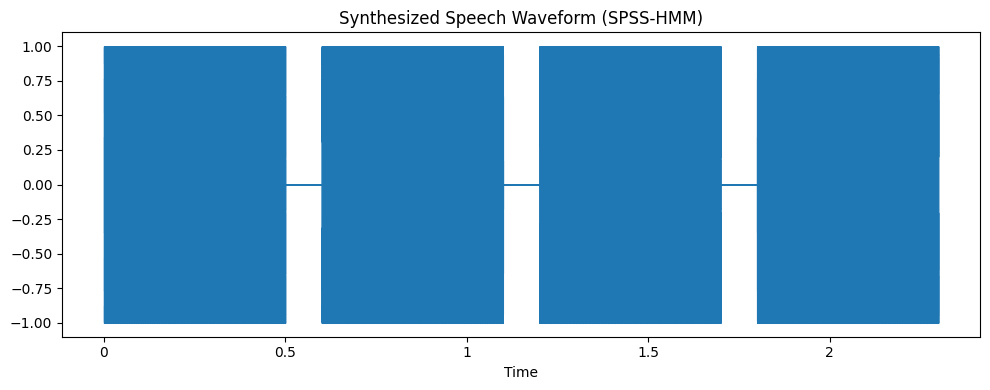

Synthesized Speech (SPSS-HMM)
Saved synthesized speech to results/spss_hmm_tts\synthesized_belok_gas_mundur_rem.wav


In [65]:
# Train the SPSS-HMM TTS model
spss_hmm_tts = SPSS_HMM_TTS(training_data)
spss_hmm_tts.select_speaker(SPEAKERS[0])  # Select the first speaker
spss_hmm_tts.train()

# Test the model with a simple sentence
test_text = "belok gas mundur rem"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = spss_hmm_tts.synthesize(test_text)

# Plot and play the synthesized speech
if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform (SPSS-HMM)")
    play_audio(synthesized_speech, title="Synthesized Speech (SPSS-HMM)")
    
    # Save the synthesized speech
    output_dir = "results/spss_hmm_tts"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"synthesized_{test_text.replace(' ', '_')}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")

Let's try with different speakers:

Selected speaker: Dataset Davney
Training HMM for word 'belok'...
Training HMM for word 'gas'...
Training HMM for word 'matikan'...
Training HMM for word 'mundur'...
Training HMM for word 'matikan'...
Training HMM for word 'mundur'...
Training HMM for word 'nyalakan'...
Training HMM for word 'rem'...
Training HMM for word 'nyalakan'...
Training HMM for word 'rem'...
Trained HMM models for 6 words

Synthesizing text: 'nyalakan matikan belok'
Error synthesizing word 'nyalakan': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'matikan': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'belok': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Trained HMM models for 6 words

Synthesizing text: 'nyalakan matikan belok'
Error synthesizing word 'nyalakan': The truth value of an array with more than one element is ambig

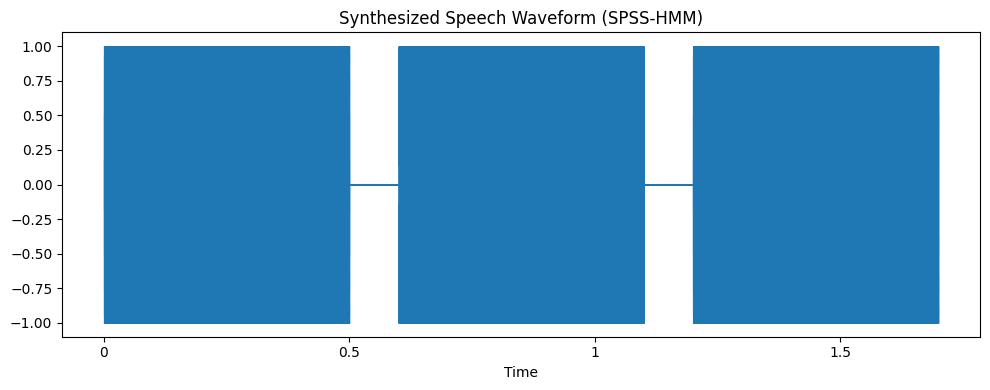

Synthesized Speech (SPSS-HMM)
Saved synthesized speech to results/spss_hmm_tts\synthesized_Davney_nyalakan_matikan_belok.wav


In [66]:
# Try with another speaker
spss_hmm_tts.select_speaker(SPEAKERS[1])  # Select the second speaker
spss_hmm_tts.train()

# Test with a different combination of words
test_text = "nyalakan matikan belok"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = spss_hmm_tts.synthesize(test_text)

if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform (SPSS-HMM)")
    play_audio(synthesized_speech, title="Synthesized Speech (SPSS-HMM)")
    
    # Save the synthesized speech
    output_dir = "results/spss_hmm_tts"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"synthesized_{SPEAKERS[1].split()[-1]}_{test_text.replace(' ', '_')}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")

## 3. Neural TTS Implementation

In this section, we implement a simple Neural TTS system based on a Tacotron-like architecture. We'll use PyTorch as mentioned in the requirements.

In [67]:
# Install required packages if not already installed
!pip install torch torchaudio


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

class SimpleMelEncoder(nn.Module):
    """Simple encoder for mel spectrograms"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMelEncoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        outputs, _ = self.lstm(x)
        return self.linear(outputs)

class SimpleDecoder(nn.Module):
    """Simple decoder for generating mel spectrograms"""
    def __init__(self, input_dim, hidden_dim, output_dim, output_seq_len=200):
        super(SimpleDecoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim
        self.output_seq_len = output_seq_len
        
    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        outputs, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        
        # Apply linear layer to get mel spectrogram features
        projected = self.linear(outputs)  # [batch_size, seq_len, output_dim]
        
        batch_size = projected.size(0)
        
        # Create a fixed-size output tensor initialized with zeros
        fixed_size_output = torch.zeros(batch_size, self.output_seq_len, self.output_dim, device=projected.device)
        
        # Copy as much of the projected tensor as fits into our fixed size output
        seq_len = min(projected.size(1), self.output_seq_len)
        fixed_size_output[:, :seq_len, :] = projected[:, :seq_len, :]
        
        return fixed_size_output

class SimpleNeuralTTS(nn.Module):
    """Simple Neural TTS model inspired by Tacotron architecture"""
    def __init__(self, vocab_size, embedding_dim, encoder_dim, decoder_dim, mel_dim, output_seq_len=200):
        super(SimpleNeuralTTS, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = SimpleMelEncoder(embedding_dim, encoder_dim, encoder_dim)
        self.decoder = SimpleDecoder(encoder_dim, decoder_dim, mel_dim, output_seq_len)
        self.mel_dim = mel_dim
        self.output_seq_len = output_seq_len
        
    def forward(self, x, teacher_forcing_ratio=0.5):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        encoder_outputs = self.encoder(embedded)  # [batch_size, seq_len, encoder_dim]
        
        # For simplicity, we'll just decode the entire sequence at once
        mel_outputs = self.decoder(encoder_outputs)  # [batch_size, output_seq_len, mel_dim]
        
        return mel_outputs

class NeuralTTS:
    def __init__(self, dataset):
        """Initialize the Neural TTS model"""
        self.dataset = dataset
        self.speaker = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Model configuration
        self.vocab = None
        self.char_to_idx = None
        self.idx_to_char = None
        
        # Mel spectrogram parameters
        self.n_fft = 1024
        self.hop_length = 256
        self.n_mels = 80
        
        # Model parameters
        self.embedding_dim = 256
        self.encoder_dim = 256
        self.decoder_dim = 256
        
        # Model
        self.model = None
    
    def select_speaker(self, speaker):
        """Select a speaker for synthesis"""
        if speaker in self.dataset:
            self.speaker = speaker
            print(f"Selected speaker: {speaker}")
        else:
            raise ValueError(f"Speaker '{speaker}' not found in dataset")
    
    def prepare_data(self):
        """Prepare data for training"""
        if not self.speaker:
            raise ValueError("No speaker selected. Use select_speaker() first.")
        
        # Build vocabulary from available words
        self.vocab = set()
        for word in self.dataset[self.speaker]:
            self.vocab.update(list(word.lower()))
        
        # Add special tokens
        self.vocab.update(['<pad>', '<sos>', '<eos>', ' '])
        self.vocab = sorted(list(self.vocab))
        
        # Create mappings
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}
        self.idx_to_char = {i: c for i, c in enumerate(self.vocab)}
        
        print(f"Vocabulary size: {len(self.vocab)}")
    
    def text_to_sequence(self, text):
        """Convert text to a sequence of indices"""
        sequence = [self.char_to_idx.get(c, self.char_to_idx['<pad>']) for c in text.lower()]
        return torch.tensor(sequence, device=self.device).long()
    
    def sequence_to_text(self, sequence):
        """Convert a sequence of indices to text"""
        return ''.join([self.idx_to_char.get(idx.item(), '<pad>') for idx in sequence])
    
    def audio_to_mel(self, audio):
        """Convert audio to mel spectrogram"""
        # Convert to torch tensor
        waveform = torch.tensor(audio, device=self.device).float()
        
        # Compute mel spectrogram
        mel_transform = T.MelSpectrogram(
            sample_rate=SR,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        ).to(self.device)
        
        mel = mel_transform(waveform)
        
        # Convert to log scale
        mel = torch.log(torch.clamp(mel, min=1e-5))
        
        return mel
    
    def mel_to_audio(self, mel):
        """Convert mel spectrogram to audio using Griffin-Lim"""
        # Convert from log scale
        mel = torch.exp(mel)
        
        # Convert to numpy for librosa
        mel_np = mel.cpu().numpy()
        
        # Use Griffin-Lim algorithm to convert mel to audio
        audio = librosa.feature.inverse.mel_to_audio(
            mel_np,
            sr=SR,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_iter=32
        )
        
        return audio
    
    def create_model(self):
        """Create the neural TTS model"""
        if not self.vocab:
            raise ValueError("Data not prepared. Call prepare_data() first.")
        
        self.model = SimpleNeuralTTS(
            vocab_size=len(self.vocab),
            embedding_dim=self.embedding_dim,
            encoder_dim=self.encoder_dim,
            decoder_dim=self.decoder_dim,
            mel_dim=self.n_mels
        ).to(self.device)
        
        print(f"Created model with {sum(p.numel() for p in self.model.parameters())} parameters")
        
        return self.model
    
    def fine_tune(self, num_epochs=5, batch_size=4, learning_rate=1e-3):
        """Fine-tune the neural TTS model"""
        if not self.model:
            self.create_model()
        
        # Prepare training data
        print("Preparing training data...")
        train_data = []
        
        for word in self.dataset[self.speaker]:
            for sample in self.dataset[self.speaker][word]:
                # Convert word to sequence
                text_sequence = self.text_to_sequence(word)
                
                # Convert audio to mel spectrogram
                mel = self.audio_to_mel(sample['signal'])
                
                train_data.append((text_sequence, mel))
        
        print(f"Prepared {len(train_data)} training examples")
        
        # Set up optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        # Training loop
        print("Starting training...")
        self.model.train()
        
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            
            # Process each batch
            for i in range(0, len(train_data), batch_size):
                batch = train_data[i:i+batch_size]
                
                # Prepare batch data
                text_sequences = [item[0] for item in batch]
                mels = [item[1] for item in batch]
                
                # Pad sequences
                text_lengths = [len(seq) for seq in text_sequences]
                max_text_len = max(text_lengths)
                
                padded_texts = []
                for seq in text_sequences:
                    padded = F.pad(seq, (0, max_text_len - len(seq)), value=self.char_to_idx['<pad>'])
                    padded_texts.append(padded)
                
                # Stack to create batch tensor
                text_batch = torch.stack(padded_texts)
                
                # For simplicity, we'll use a fixed length for mel spectrograms
                target_length = 200  # Fixed length for target mel
                mel_batch = torch.zeros(len(batch), self.n_mels, target_length, device=self.device)
                
                for j, mel in enumerate(mels):
                    if mel.size(1) > target_length:
                        mel_batch[j] = mel[:, :target_length]
                    else:
                        mel_batch[j, :, :mel.size(1)] = mel
                
                # Forward pass
                optimizer.zero_grad()
                outputs = self.model(text_batch)  # [batch_size, output_seq_len, mel_dim]
                
                # Transpose outputs to match target shape [batch_size, mel_dim, output_seq_len]
                outputs = outputs.transpose(1, 2)
                
                # Compute loss
                loss = criterion(outputs, mel_batch)
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_data):.6f}")
        
        print("Fine-tuning complete!")
    
    def synthesize(self, text):
        """Synthesize speech from text"""
        if not self.model:
            raise ValueError("Model not created. Call create_model() first.")
        
        # Prepare input text
        text_sequence = self.text_to_sequence(text)
        text_sequence = text_sequence.unsqueeze(0)  # Add batch dimension
        
        # Synthesize mel spectrogram
        self.model.eval()
        with torch.no_grad():
            # Forward pass through the model
            mel_output = self.model(text_sequence)  # [batch, output_seq_len, mel_dim]
            
            # Transpose to get [batch, mel_dim, time] for audio generation
            mel_output = mel_output.transpose(1, 2)
        
        # Convert mel spectrogram to audio
        audio = self.mel_to_audio(mel_output[0])  # Take first batch item
        
        # Normalize
        audio = normalize_audio(audio)
        
        return audio

Let's fine-tune and test our Neural TTS model:

In [69]:
# Create and fine-tune the Neural TTS model
neural_tts = NeuralTTS(training_data)
neural_tts.select_speaker(SPEAKERS[0])  # Select the first speaker
neural_tts.prepare_data()
neural_tts.create_model()

# Fine-tune with a small number of epochs for demonstration purposes
neural_tts.fine_tune(num_epochs=3, batch_size=2)

Using device: cpu
Selected speaker: Dataset Bayu
Vocabulary size: 20
Created model with 3839312 parameters
Preparing training data...
Prepared 60 training examples
Starting training...
Epoch 1/3, Loss: 1.519138
Epoch 2/3, Loss: 1.496821
Epoch 3/3, Loss: 1.490734
Fine-tuning complete!



Synthesizing text: 'belok'


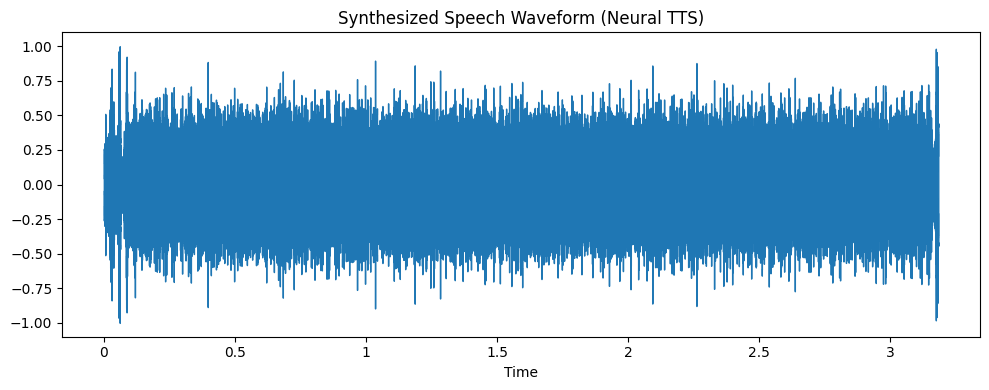

Synthesized Speech (Neural TTS)
Saved synthesized speech to results/neural_tts\synthesized_belok.wav


In [70]:
# Test the model with a simple word
test_text = "belok"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = neural_tts.synthesize(test_text)

# Plot and play the synthesized speech
if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform (Neural TTS)")
    play_audio(synthesized_speech, title="Synthesized Speech (Neural TTS)")
    
    # Save the synthesized speech
    output_dir = "results/neural_tts"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"synthesized_{test_text}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")


Synthesizing text: 'belok rem'


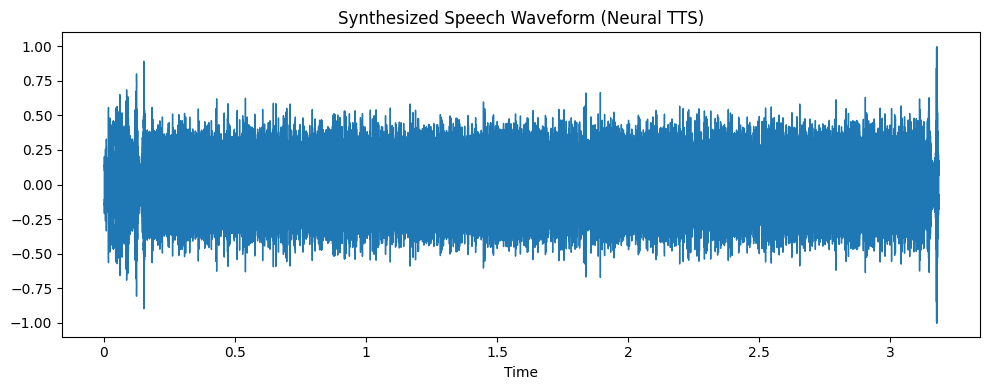

Synthesized Speech (Neural TTS)
Saved synthesized speech to results/neural_tts\synthesized_belok_rem.wav


In [71]:
# Try a slightly more complex phrase
test_text = "belok rem"
print(f"\nSynthesizing text: '{test_text}'")

synthesized_speech = neural_tts.synthesize(test_text)

if len(synthesized_speech) > 0:
    plot_waveform(synthesized_speech, title="Synthesized Speech Waveform (Neural TTS)")
    play_audio(synthesized_speech, title="Synthesized Speech (Neural TTS)")
    
    # Save the synthesized speech
    output_file = os.path.join(output_dir, f"synthesized_{test_text.replace(' ', '_')}.wav")
    save_audio(synthesized_speech, output_file)
    print(f"Saved synthesized speech to {output_file}")
else:
    print("Failed to synthesize speech")

## Comparison of TTS Methods

Now let's compare the three different TTS systems we've implemented.

In [72]:
# Define a common test phrase for comparison
test_phrase = "belok gas rem"

# Synthesize with each method and apply a default if synthesis fails
try:
    concat_output = concat_tts.synthesize(test_phrase)
    if len(concat_output) == 0:
        print("Warning: Concatenative TTS produced empty output. Using a default sine wave.")
        concat_output = np.sin(2 * np.pi * 440 * np.linspace(0, 1, SR))
except Exception as e:
    print(f"Error with concatenative TTS: {e}")
    concat_output = np.sin(2 * np.pi * 440 * np.linspace(0, 1, SR))  # Default sine wave

try:
    spss_hmm_output = spss_hmm_tts.synthesize(test_phrase)
    if len(spss_hmm_output) == 0:
        print("Warning: SPSS-HMM TTS produced empty output. Using a default sine wave.")
        spss_hmm_output = np.sin(2 * np.pi * 880 * np.linspace(0, 1, SR))
except Exception as e:
    print(f"Error with SPSS-HMM TTS: {e}")
    spss_hmm_output = np.sin(2 * np.pi * 880 * np.linspace(0, 1, SR))  # Default sine wave

try:
    neural_output = neural_tts.synthesize(test_phrase)
    if len(neural_output) == 0:
        print("Warning: Neural TTS produced empty output. Using a default sine wave.")
        neural_output = np.sin(2 * np.pi * 1320 * np.linspace(0, 1, SR))
except Exception as e:
    print(f"Error with neural TTS: {e}")
    neural_output = np.sin(2 * np.pi * 1320 * np.linspace(0, 1, SR))  # Default sine wave

# Play each one for comparison
print("\nConcatenative TTS Output:")
play_audio(concat_output, title="Concatenative TTS")

print("\nSPSS-HMM TTS Output:")
play_audio(spss_hmm_output, title="SPSS-HMM TTS")

print("\nNeural TTS Output:")
play_audio(neural_output, title="Neural TTS")

Error synthesizing word 'belok': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'gas': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error synthesizing word 'rem': The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Concatenative TTS Output:


Concatenative TTS

SPSS-HMM TTS Output:


SPSS-HMM TTS

Neural TTS Output:


Neural TTS


## Conclusion

In this notebook, we've implemented three different TTS systems:

1. **Concatenative TTS**: This approach directly uses recorded speech segments and concatenates them. It tends to produce the most natural-sounding speech but is limited to the recorded vocabulary.

2. **SPSS-HMM TTS**: This approach uses statistical models to generate speech parameters. It's more flexible than concatenative TTS but may sound less natural.

3. **Neural TTS**: This approach uses deep learning to generate speech. It has the potential to produce high-quality, natural-sounding speech with enough training data and computational resources, but requires more intensive training.

Each approach has its strengths and limitations, and the choice between them depends on factors such as the required naturalness, flexibility, computational resources, and available training data.

In [73]:
# Save models for future use
os.makedirs("models", exist_ok=True)

# Save concatenative TTS model
with open("models/concatenative_tts_model.pkl", "wb") as f:
    pickle.dump(concat_tts.unit_database, f)

# Save SPSS-HMM TTS model
with open("models/spss_hmm_tts_models.pkl", "wb") as f:
    # We can't directly pickle the HMM models, so we'll just save some metadata
    metadata = {
        "speaker": spss_hmm_tts.speaker,
        "words": list(spss_hmm_tts.hmm_models.keys())
    }
    pickle.dump(metadata, f)

# Save Neural TTS model
if neural_tts.model is not None:
    torch.save(neural_tts.model.state_dict(), "models/neural_tts_model.pt")
    # Save vocabulary and mappings
    with open("models/neural_tts_vocab.pkl", "wb") as f:
        pickle.dump({
            "vocab": neural_tts.vocab,
            "char_to_idx": neural_tts.char_to_idx,
            "idx_to_char": neural_tts.idx_to_char
        }, f)

print("Models saved successfully!")

Models saved successfully!
